In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
import random

In [2]:
images = np.load('object_images.npy')

In [3]:
voxels = np.load('object_voxels_filtered_0.npy')

In [4]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()

In [5]:
train_images = images[1:2000]
val_images = images[2000:2010]
train_voxels = voxels[1:2000]
val_voxels = voxels[2000:2010]

Displaying the object


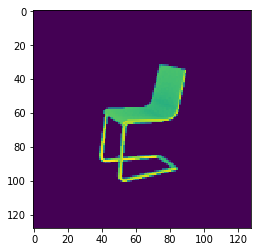

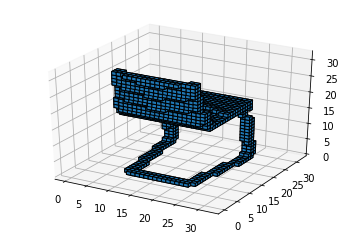

In [6]:
display_id = 56
batch_size = 1
train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id][0])
display3DObject(train_voxels[display_id])

In [7]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, sigma
        

In [88]:
class aggregator(nn.Module):
    def __init__(self, input_size = 400,  z_size=200, h_dim=200, n_layers=1, batch_size=1):
        super(aggregator, self).__init__()
        self.h_dim, self.h_dim, self.n_layers= z_size, h_dim, n_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=h_dim, num_layers=n_layers)
        self.hidden_to_z_size = nn.Linear(self.h_dim, z_size)
        self.reInitialize(batch_size)
        
    def reInitialize(self, batch_size):
        self.hidden = (Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda(), Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda())
    
    def getInitial(self,batch_size):
        return (Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda(), Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda())
    
    def setHiddenState(self, hidden):
        self.hidden = hidden
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        output_state = self.hidden_to_z_size(lstm_out[0,0,:])
        current_state = lstm_out[0,0,:]
        return current_state, self.hidden

In [89]:
class controller(nn.Module):
    def __init__(self, input_size = 400, z_size=200, hidden_size = 100):
        super(controller, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,  z_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        return self.fc2(out)

In [95]:
class MVRNN(nn.Module):
    def __init__(self, z_size=200, batch_size=1):
        super(MVRNN, self).__init__()
        self.z_size = z_size
        self.batch_size = batch_size
        self.vae = VAE()
        self.agg = aggregator()
        self.cont = controller()
        
    def forward(self, x, seqn):
        # x is [Sequence, Batch, channel, h, w]
        current_state = None
        predicted = [] 
        mus = []
        sigmas = []
        states = []
        objects =[]
        self.agg.reInitialize(self.batch_size)
        last_action = Variable(torch.zeros(1,1,200)).cuda()
        for i in range(seqn):
            #print(i)
            mu, sigma= self.vae.encoder(x[i])
            mus.append(mu)
            sigmas.append(sigma)
            latent = self.vae.reparametrize(mu,sigma)
            latent = latent.view(1,self.batch_size,self.z_size)
            memory_input = torch.cat([latent] + [last_action],dim=-1)
#             print(memory_input.shape)
            predicted_state, memory_hidden = self.agg.forward(memory_input)
            self.agg.setHiddenState(memory_hidden)
            #print(predicted_state.shape)
            controller_input = torch.cat((predicted_state, latent.squeeze()), dim=-1)
            #print(controller_input.shape)
            latent_3d = self.cont.forward(controller_input)
            #print(latent_3d.shape)
            states.append(latent_3d)
            #print("Latent Shape", current_state.shape)
            latent_3d = latent_3d.view(-1,self.z_size,1,1,1)
            last_action = latent_3d.view(1,1,200)
            #print(last_action.shape)
            object_3D = self.vae.decoder(latent_3d)
            objects.append(object_3D)
        return objects, mus, sigmas
            
        

In [94]:
mvrnn = MVRNN().cuda()
test_image = Variable(torch.FloatTensor(images[0])).unsqueeze(1).unsqueeze(1).cuda()
print(test_image.shape)
object_3ds, _, _ = mvrnn.forward(test_image, 12)
print(object_3ds[0].shape)
# object_3d.shape

torch.Size([12, 1, 1, 128, 128])
torch.Size([1, 1, 32, 32, 32])


In [96]:
mvrnn = MVRNN().cuda()
lr_vae = 0.0003
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
mvrnn_solver = optim.Adam(mvrnn.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [104]:
lr_vae = 0.003
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
mvrnn_solver = optim.Adam(mvrnn.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [111]:
#Training the mvcnn arch 
num_epochs = 500
max_seq_len = 12
val_images = torch.FloatTensor(val_images)
val_voxels = torch.FloatTensor(val_voxels)
loss = nn.BCELoss(size_average=False)
for epoch in range(num_epochs):
    mvvae_losses = []
    klds = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        seq_len = 12#random.randint(1,max_seq_len-1)
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float().view(max_seq_len,1,1,128,128)
        generated_objects, mus, logvars = mvrnn(var_2D_data, seq_len)
        loss_ = 0
        KLD = 0 
        for i in range(seq_len):
            
            #print(var_3D_data.shape)
                # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #         KLD_element = mu.pow(2).add_(sigma.exp()).mul_(-1).add_(1).add_(sigma)
    #         KLD = torch.sum(KLD_element).mul_(-0.5)
            # https://arxiv.org/abs/1312.6114
            #print(logvar.shape)
            kld =  -0.5 * torch.sum(1 + logvars[i] - mus[i].pow(2) - logvars[i].exp())
            #rint(KLD)
            generated_object = generated_objects[i].squeeze()
            loss_ = loss_+ loss(generated_object, var_3D_data.squeeze()) + kld
            KLD = KLD + kld
        mvrnn.zero_grad()
        loss_.backward()
        mvrnn_solver.step()
        mvvae_losses.append(loss_)
        klds.append(KLD)
#     random_val = random.randint(1,10-1)
#     seq_len = random.randint(1,max_seq_len-1)
#     val_3D_data = Variable(val_voxels[random_val]).cuda().float()
#     val_2D_data = Variable(val_images[random_val]).cuda().float().view(max_seq_len,1,1,128,128)
#     generated_object_val, mu, sigma = mvrnn(val_2D_data,seq_len)
#     generated_object_val = torch.round(generated_object_val.squeeze())
#     accuracy = np.mean((generated_object_val  == val_3D_data.squeeze()).squeeze().data.cpu().numpy())
    mvvae_losses_mean = np.mean(np.concatenate(mvvae_losses))
    kld_mean =  np.mean(np.concatenate(klds)).data.cpu().numpy()[0]
    print("Epoch: ", epoch, '\n', "MV RNN loss: ", mvvae_losses_mean.data.cpu().numpy()[0])
    print( "KLD loss: ", kld_mean) #"Accuracy", accuracy,

Epoch:  0 
 MV RNN loss:  88825.875
KLD loss:  905.87524
Epoch:  1 
 MV RNN loss:  88561.516
KLD loss:  981.4985
Epoch:  2 
 MV RNN loss:  88115.01
KLD loss:  994.5872


KeyboardInterrupt: 

torch.Size([12, 1, 1, 128, 128])
Displaying the object


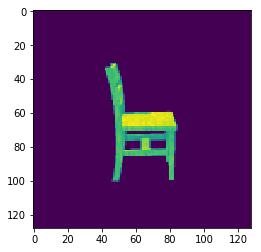

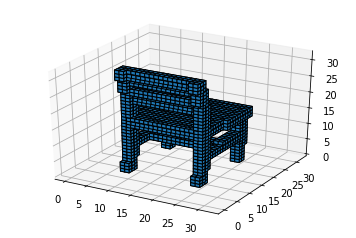

Displaying the object


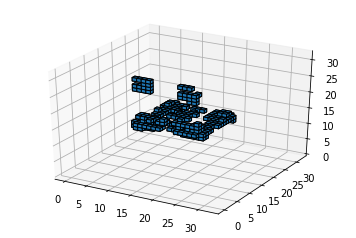

In [113]:
# #Testing the mvcnn architecture 

# mvcn = mvcnn().cuda()

#print(val_images[1:2])
i = 4100
seq = 12
test_image = Variable(torch.FloatTensor(images[i:i+1])).cuda()
test_image = test_image[0][0:seq].view(seq,1,1,128,128)
print(test_image.shape)
# #test_image = test_image[0][0:1].unsqueeze(1)
# print(test_image.shape) 

test_object, _, _ = mvrnn(test_image, seq)

plt.imshow(images[i][0])
# display3DObject(Variable(voxels[i]).data.cpu().numpy())
display3DObject(voxels[i])
display3DObject(test_object[0].squeeze().data.cpu().numpy()>0.5)

In [ ]:
max_seq_len = 12
for batch_idx, (data3d, data2d) in enumerate(train_loader):
    var_2D_data = Variable(data2d).cuda().float()
    print(var_2D_data.view(max_seq_len,1,1,128,128).shape)

In [53]:
#Testing the RNN 
mvrnn = MVRNN().cuda()
test_image = Variable(torch.FloatTensor(images[0])).unsqueeze(1).unsqueeze(1).cuda()
print(test_image.shape)
object_3d, _, _ = mvrnn.forward(test_image, 12)
object_3d.shape

torch.Size([12, 1, 1, 128, 128])
0
1
2
3
4
5
6
7
8
9
10
11
Latent Shape torch.Size([200])


torch.Size([1, 1, 32, 32, 32])

In [77]:
val_voxels.shape

torch.Size([10, 32, 32, 32])

In [80]:
val_images[3][4].shape

torch.Size([128, 128])